In [1]:
import os
import configparser

import numpy as np
import pandas as pd

from source.processes import Shuffler
from source.datamodels.datamodels import GridSearchResults
from source.datamodels.datamodels import Axes, Stats
from source.utils import get_project_root

In [2]:
root = get_project_root()
config = configparser.ConfigParser()
config.read(os.path.join(root, "userconfig.ini"))

own_data_path = config['Path']['own_data_path']
third_party_data_path = config['Path']['third_party_data_path']
Cesar1_path = config['Path']['Cesar1_path']

images_path = config['Path']['images_path']
public_images_path = config['Path']['public_images_path']

tables_path = config['Path']['tables_path']
public_tables_path = config['Path']['public_tables_path']

bootstrap_jsons_path = config['Path']['bootstrap_jsons_path']
single_jsons_path = config['Path']['single_jsons_path']

In [3]:
prepared_data = pd.read_csv(os.path.join(root, own_data_path, 'processed_AY_full_signal_specter500_noscale.csv'), delimiter=',')  # our experiment
prepared_data.head()

,target,group,a1_x_signal_zero_crossing,a1_x_signal_skew,a1_x_signal_shannon_entropy,a1_x_signal_svd_entropy,a1_x_signal_complexity,a1_x_signal_mean,a1_x_signal_variation,a1_x_signal_kurtosis,...,a2_z_specter_permutation_entropy,a2_z_specter_energy,a2_z_specter_hurst,a2_z_specter_activity,a2_z_specter_petrosian_fd,a2_z_specter_iqr,a2_z_specter_std,a2_z_specter_detrended_fluctuation,a2_z_specter_crest_factor,a2_z_specter_approx_entropy
0,0.0,1.0,451.0,-0.231906,6.388020,0.750154,1.865568,-0.208098,-9.989303,-0.337526,...,2.584111,7.764350e+05,0.735075,1.067684,1.035657,2.625193,28.365530,0.633373,11.710311,0.313429
1,0.0,1.0,437.0,0.046480,6.507361,0.746400,1.812863,-0.266600,-8.479932,-0.329388,...,2.584124,7.808807e+05,0.695679,1.142286,1.035379,2.555386,28.673409,0.591263,13.562794,0.311777
2,0.0,1.0,454.0,0.014204,6.489806,0.752397,1.775775,-0.233430,-9.585973,-0.439591,...,2.574985,1.045814e+06,0.670514,1.173990,1.033761,2.404519,33.369965,0.612593,15.268013,0.298894
3,0.0,1.0,417.0,-0.145760,6.422261,0.747309,1.912905,-0.232290,-9.033494,-0.364524,...,2.583600,2.238557e+06,0.598747,1.303795,1.035268,2.309265,49.300425,0.547850,18.815380,0.207563
4,0.0,1.0,457.0,-0.149621,6.449559,0.755040,1.868826,-0.254059,-8.482620,0.017384,...,2.579343,1.489274e+06,0.631251,1.211011,1.035879,2.404522,40.065136,0.541767,15.595560,0.264668


In [4]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [5]:
LR_estimator = LogisticRegression(max_iter=100000)
SVC_estimator = SVC()
RFC_estimator = RandomForestClassifier()
GBM_estimator = GradientBoostingClassifier()
KNN_estimator = KNeighborsClassifier()

In [6]:
LR_grid = {"C": list(np.logspace(-3, 6, 10))}  # np.ndarrays are not serializable
SVC_grid = {"C": list(np.logspace(-3, 6, 10)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
RFC_grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [3, 5, 9, 15, 30]}
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 35], 'p': [1, 1.5, 2, 2.5, 6, 100]}

In [8]:
X = prepared_data.drop(columns=['target', 'group']).values
y = prepared_data['target'].values
groups = prepared_data['group'].values

X_scaled = StandardScaler().fit_transform(X)

In [64]:
from datetime import datetime
from source.datamodels.iterators import Metrics

GS_results_objects = []

estimators = [LR_estimator, SVC_estimator, RFC_estimator, KNN_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, KNN_grid]
names = ['LR', 'SVC', 'RFC', 'KNN']

n_repeats = 100
score_names = Metrics.get_scorers_dict()

for estimator, grid, name in zip(estimators, grids, names):
    json_grid = dict()
    for key, val in zip (grid.keys(), grid.values()):
        if isinstance(val, np.ndarray):
            json_grid[key] = list(val)
        else:
            json_grid[key] = val
    start_time = datetime.now()
    cv = Shuffler.OverlapGroupCV(train_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_names, cv=cv, refit="f1")
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}")

    highest_score_params = GSCV.best_index_
    bootstrap_scores_distr = dict()
    scores = dict()
    for score_name in score_names.keys():

        split_scores_names = [f'split{idx}_test_{score_name}' for idx in range(n_repeats)]

        scores_distr = []
        for split_scores_name in split_scores_names:
            scores_distr.append(float(GSCV.cv_results_[split_scores_name][highest_score_params]))
        bootstrap_scores_distr[score_name] = scores_distr.copy()
        scores[score_name] = np.mean(scores_distr)

    res = GridSearchResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        hyperparameters_grid = json_grid,
        use_signal = True,
        use_specter = True,
        specter_threshold = 500,
        axes = Axes.get_keys(),
        stats = Stats.get_keys(),
        predictions = None,
        scores = scores,
        resampling_number = n_repeats,
        bootstrap_scores =  bootstrap_scores_distr
    )
    GS_results_objects.append(res)

{'accuracy': make_scorer(score_func), 'precision': make_scorer(score_func), 'recall': make_scorer(score_func), 'f1': make_scorer(score_func), 'TPR': make_scorer(score_func), 'TNR': make_scorer(score_func)}


F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

Best score for LR: 83.121% 
 best params: {'C': 10000.0}
 required time: 0:00:03.567300


##

In [10]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects, filenames=[f"{model}_GS_AY_signal_spectrum500_noscale_18stats.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch'))

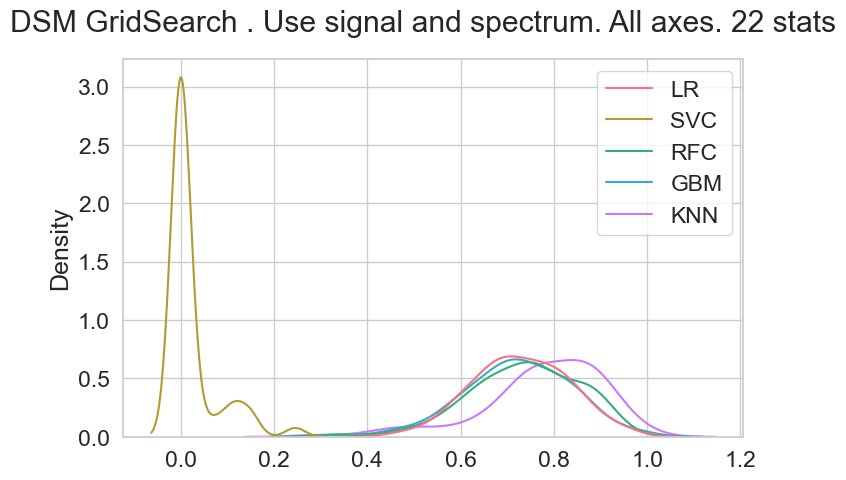

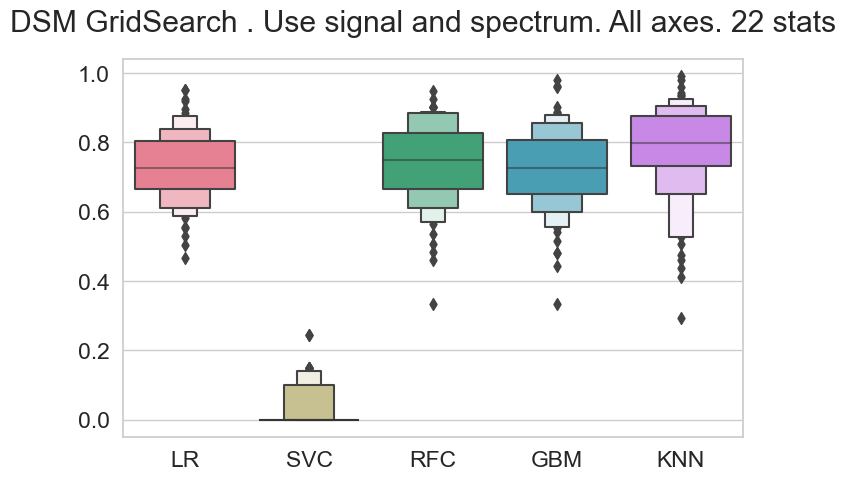

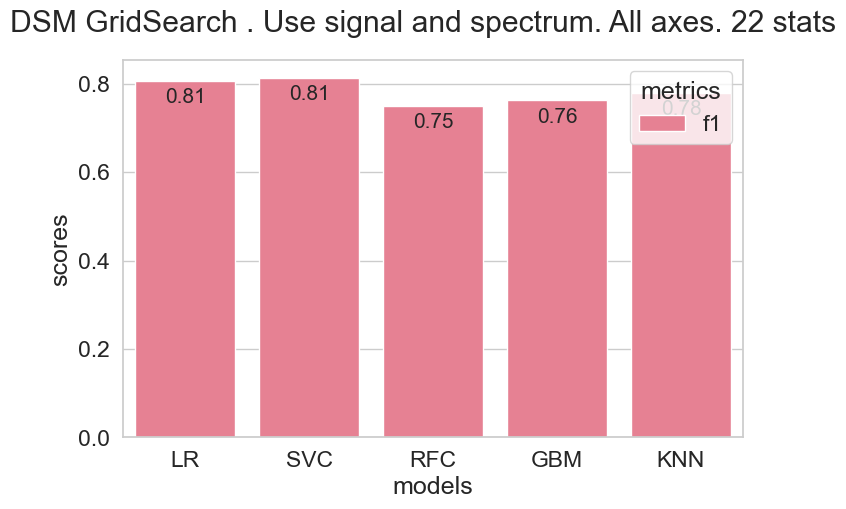

In [12]:
from source.postprocessing.plotter import dist_plot, bar_plot


plot_info = '. Use signal and spectrum. All axes. 22 stats'
filename_info = 'GS_AFull_22stats'
dist_plot(results=GS_results_objects, models=names, plot_type='kdeplot', metric='f1', title=f'DSM GridSearch {plot_info}', to_png=True, filename=f'kde_DSM_{filename_info}_4_11_2021.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

dist_plot(results=GS_results_objects, models=names, plot_type='boxenplot', metric='f1', title=f'DSM GridSearch {plot_info}', to_png=True, filename=f'box_DSM_{filename_info}_4_11_2021.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

bar_plot(results=GS_results_objects, models=names, metrics=['f1'], title=f'DSM GridSearch {plot_info}', plot_vals=True, to_png=True, filename=f'bar_DSM_{filename_info}_4_11_2021.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

In [27]:
from source.postprocessing.mlcsv import generate_csv_from_results, append_results_to_csv, create_readable_xlsx
from source.postprocessing.mljson import deserialize_results

# generate_csv_from_results(GS_results_objects, "DSM_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
# append_results_to_csv(GS_results_objects, "DSM_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
whole_results = deserialize_results(GridSearchResults, filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch'))
generate_csv_from_results(whole_results, "DSM_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("GridSearch results.xlsx", "DSM_GS.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))